# CS492F 전산학특강<인공지능 산업 및 스마트에너지>
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

## Advanced Models
### Deep Convolutional Generative Adversarial Network

This practice demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

### What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](images/gan1.png)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](images/gan2.png)

This practice demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![Sample output](images/dcgan.gif)

To learn more about GANs, we recommend MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Import TensorFlow and other libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# To generate GIFs
!pip install imageio

### Load and prepare the dataset

We are going to use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [6]:
buffer_size = 60000
batch_size = 256

Use `tf.data` to create batches and shuffle the dataset

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

## Create the models

We will use [`tf.keras.Sequential`](https://tensorflow.google.cn/api_docs/python/tf/keras/Sequential) API to define the generator and discriminator models.

### The Generator

The generator is responsible for creating convincing images that are good enough to fool the discriminator. The network architecture for the generator consists of `tf.keras.layers.Conv2DTranspose` (Upsampling) layers. We start with a `tf.keras.layers.Dense` layer and upsample the image two times in order to reach the desired image size of 28x28x1. We increase the width and height, and reduce the depth as we move through the layers in the network. We will use `tf.keras.layers.LeakyReLU` activation for each layer except for the last one where we use a tanh activation.

In [8]:
def build_generator():
    

Let the generator (as yet untrained) create an image from an input noise.

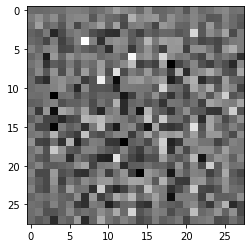

In [9]:
generator = build_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is responsible for distinguishing fake images from real images. It's similar to a regular CNN-based image classifier.

In [10]:
def build_discriminator():
    

Let the discriminator (as yet untrained) classify the generated images as *real* or *fake*. The model will be trained to **output positive values for real images**, and **negative values for fake images**.

In [11]:
discriminator = build_discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00092211]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Let's define the loss functions and the optimizers for the generator and the discriminator.

### Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, **if the generator is performing well, the discriminator will classify the fake images as real (or 1)**. Here, we will compare the discriminators decisions on the generated images to an array of 1s. Here, we will use `tf.losses.sigmoid_cross_entropy` to calculate the generator loss.

In [12]:
cross_entropy = 

def calculate_generator_loss(generated_output):
    

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from generated images. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

Here is the detailed procedure to calculate the discriminator loss:

1. Calculate `real_loss` which is a sigmoid cross entropy loss of the real images and an array of ones (since these are the real images).
2. Calculate `generated_loss` which is a sigmoid cross entropy loss of the generated images and an array of zeros (since these are the fake images).
3. Calculate the `total_loss` as the sum of `real_loss` and `generated_loss`.

In [13]:
def calculate_discriminator_loss(real_output, generated_output):
    

The discriminator and the generator optimizers are different since we will train two networks separately.

In [14]:
generator_optimizer = 
discriminator_optimizer = 

## Set up GANs for Training

Now it's time to put together the generator and discriminator to set up the Generative Adversarial Networks, as you see in the diagram at the beginning of this lecture.

### Define training parameters

In [15]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime to visualize progress in the animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### Define training loop

We start by iterating over the dataset. The generator will receive a random seed as an input which is processed to output an image looking like a handwritten digit. The discriminator is then shown the real MNIST images as well as the generated images.

Next, we calculate the generator and the discriminator loss. Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables.

In [16]:
def train_step(images):


In [17]:
import os
import time
from IPython import display

def generate_images(model, seed):
    predictions = model(seed, training=False)
  
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

def generate_and_save_images(model, epoch, seed):
    generate_images(model, seed)
    plt.savefig(os.path.join('dcgan', 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for images in dataset:
            train_step(images)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        print(f'Time taken for epoch {epoch + 1} is {time.time() - start} sec')
                
    # Generate images after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

## Train the model
Call the `train()` function defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits.

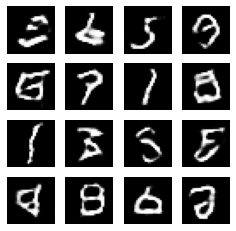

CPU times: user 8min 55s, sys: 19.1 s, total: 9min 14s
Wall time: 12min 20s


In [18]:
%%time
train(train_dataset, epochs)

## Let's generate images!

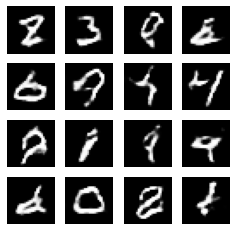

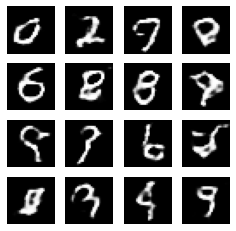

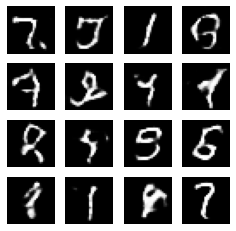

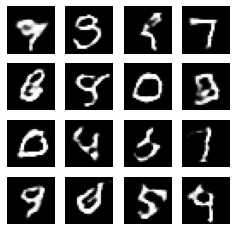

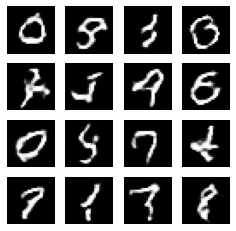

In [22]:
for _ in range(5):
    generate_images(generator, tf.random.normal([num_examples_to_generate, noise_dim]))

## Create a GIF


Use `imageio` to create an animated gif using the images saved during training.

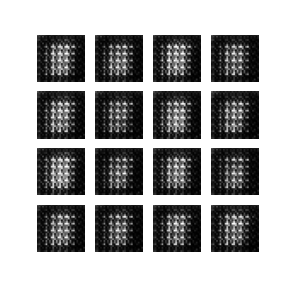

In [27]:
import glob
import imageio
from IPython import display

animated_file = os.path.join('dcgan', 'animated.gif')
with imageio.get_writer(animated_file, mode='I') as writer:
    filenames = sorted(glob.glob(os.path.join('dcgan', 'image_at_epoch_*.png')))
    
    last = -1
    for index, filename in enumerate(filenames):
        frame = 30 * (index ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
display.Image(filename=animated_file)